### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

### 1. Data Loading and Preparation

*   The `data_load` function loads class names and creates a dictionary mapping class names to labels.
*   The `data_prep` function prepares data generators for training and validation.
*   The `split_data` function splits data into features (X) and labels (y).
*   The `visualize_images_with_labels` function visualizes random images with their labels.





In [2]:
def data_load(data_directory):
    """
    Load class names and create a dictionary mapping class names to labels.

    Args:
    data_directory (str): Path to the dataset directory.

    Returns:
    tuple: A tuple containing a list of class names and a dictionary mapping class names to labels.
    """
    classes = os.listdir(data_directory)
    label_classes = {cls: idx for idx, cls in enumerate(classes)}
    return classes, label_classes

In [3]:
def data_prep(data_directory, classes, target_size=(128, 128), batch_size=32, validation_split=0.2):
    """
    Prepare the data generators for training and validation.

    Args:
    data_directory (str): Path to the dataset directory.
    classes (list): List of class labels (folder names) in dataset.
    target_size (tuple): Desired image size.
    batch_size (int): Number of samples per batch.
    validation_split (float): Fraction of data to use for validation.

    Returns:
    tuple: Training and validation data generators.
    """
    image_dt_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=validation_split)


    train_generator = image_dt_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = image_dt_gen.flow_from_directory(
        data_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(classes)
    class_labels = list(train_generator.class_indices.keys())

    print("Number of classes:", num_classes)
    print("Class labels:", class_labels)


    return train_generator, validation_generator

In [4]:
def split_data(generator):
    """
    Split data into features (X) and labels (y).

    Args:
    generator (ImageDataGenerator): Data generator.

    Returns:
    tuple: Features and labels as numpy arrays.
    """
    X, y = [], []

    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        X.extend(batch_images)
        y.extend(batch_labels)

    X = np.array(X)
    y = np.array(y)
    y = np.argmax(y, axis=1)

    print(f'İmage shape: {X.shape}')

    return X, y

In [5]:
def visualize_images_with_labels(directory, num_images=20, font_size=15):
    """
    Visualize a random selection of images with their corresponding labels.

    Args:
    directory (str): Path to the dataset directory.
    num_images (int): Number of images to visualize.
    font_size (int): Font size for labels.
    """
    datagen = ImageDataGenerator(rescale=1/255)
    data_generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=1,
        class_mode='categorical',
        shuffle=True
    )
    class_indices = {v: k for k, v in data_generator.class_indices.items()}
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()

    for i in range(num_images):
        image, label = next(data_generator)
        axes[i].imshow(image[0])
        label = int(np.argmax(label[0]))
        axes[i].set_title(class_indices[label], fontsize=font_size)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### 2. Model Building

*   The `build_model` function builds a CNN model based on the input shape and number of classes.

In [6]:
def build_model(input_shape=(128, 128, 3), num_classes=10):
    """
    Build a convolutional neural network model.

    Args:
    input_shape (tuple): Shape of the input images.
    num_classes (int): Number of output classes.

    Returns:
    Sequential: The model berfore it is compiled.
    """
    model = Sequential([
        Conv2D(32, (3, 3), padding="Same", activation="relu", input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), padding="Same", activation="relu"),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding="Same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), padding="Same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    return model

### 3. Model Training

*   The `train_model` function trains the model with early stopping and returns training history.

In [7]:
def train_model_with_best_accuracy(model, X_train, y_train, X_val, y_val, epochs=50, checkpoint_path='best_model.keras'):
    """
    Train the model with early stopping and save the best model based on validation accuracy.

    Args:
    model (Sequential): The compiled model.
    X_train (ndarray): Training data.
    y_train (ndarray): Training labels.
    X_val (ndarray): Validation data.
    y_val (ndarray): Validation labels.
    epochs (int): Number of training epochs.
    checkpoint_path (str): Path to save the best model.

    Returns:
    tuple: Trained model and training history.
    """
    num_classes = np.max(y_train) + 1
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train_onehot, epochs=epochs, validation_data=(X_val, y_val_onehot), callbacks=[early_stopping, model_checkpoint])

    return model, history

### 4. Performance Visualization

*   The `plot_accuracy` function plots training and validation accuracy over epochs.
*   The `plot_loss` function plots training and validation loss over epochs.

*   The `get_best_validation_metrics` function extracts and prints the best values for validation accuracy and loss from the training history.



In [8]:
def plot_accuracy(history):
    """
    Plot training and validation accuracy over epochs.

    Args:
    history (History): Training history.
    """
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    if 'val_accuracy' in history.history:
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Model Accuracy")
    plt.show()

In [9]:
def plot_loss(history):
    """
    Plot training and validation loss over epochs.

    Args:
    history (History): Training history.
    """
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    if 'val_loss' in history.history:
        plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.title("Model Loss")
    plt.show()

In [11]:
def get_best_validation_metrics(history):
    """
    Extracts and prints the best values for multiple validation metrics from training history.

    Args:
    history (History): Training history object.

    Returns: The function directly prints the best validation metrics.
    None
    """
    metrics = ['val_accuracy']


    print("Best Validation Metrics:")
    for metric in metrics:
        best_value = np.max(history.history[metric])
        print(f"{metric.upper()}: {best_value:.4f}")  


### 5. Random Image Prediction

*   The `predict_random_image` function predicts the class and probabilities for a random image.



In [12]:
def predict_random_image(model, data_directory, classes, target_size=(128, 128)):
    """
    Predict and visualize a randomly selected image from the dataset.

    Args:
    model (Sequential): The trained model.
    data_directory (str): Path to the dataset directory.
    classes (list): List of class names.
    target_size (tuple): Desired image size.

    Returns:
    tuple: Actual class, image file name, predicted class, and class probabilities.
    """
    class_dirs = os.listdir(data_directory)
    random_class = random.choice(class_dirs)
    class_dir = os.path.join(data_directory, random_class)
    images = os.listdir(class_dir)
    random_image = random.choice(images)
    image_path = os.path.join(class_dir, random_image)

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The specified image path does not exist: {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unable to read the image file: {image_path}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_scaled = img_resized / 255.0
    img_expanded = np.expand_dims(img_scaled, axis=0)

    predictions = model.predict(img_expanded)
    predicted_class = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Actual: {random_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(range(len(classes)), predictions[0])
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Probability')
    plt.title(f"Predicted: {classes[predicted_class[0]]}")

    plt.subplots_adjust(wspace=0.5)

    plt.show()

    return random_class, random_image, predicted_class[0], predictions

### Main Function

*   The `main` function runs all code sections and performs model training and evaluation.

In [15]:
def main():
    data_directory = r"C:\Users\erdal\Desktop\Cityscape Dataset"

    # Load and prepare data
    classes, label_classes = data_load(data_directory)
    train_generator, validation_generator = data_prep(data_directory, classes)

    # Split data into training and validation sets
    X_train, y_train = split_data(train_generator)
    X_test, y_test = split_data(validation_generator)

    # Visualize some images with labels
    visualize_images_with_labels(data_directory, num_images=20, font_size=20)

    # Build and train the model
    model = build_model(input_shape=(128, 128, 3), num_classes=len(classes))
    model.summary()
    model, history = train_model_with_best_accuracy(model, X_train, y_train, X_test, y_test, epochs=50, checkpoint_path='best_model.keras')

    # Plot accuracy and loss
    plot_accuracy(history)
    plot_loss(history)

    # Predict a random image from the dataset
    random_class, random_image, predicted_class, predictions = predict_random_image(model, data_directory, classes)
    print(f"Randomly selected image from class '{random_class}': {random_image}")
    print("Predicted class:", predicted_class)
    print("Class probabilities:", predictions)

    get_best_validation_metrics(history)

Found 6400 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.
Number of classes: 10
Class labels: ['Bridge', 'Commercial', 'Industrial', 'Intersection', 'Landmark', 'Park', 'Parking', 'Playground', 'Residential', 'Stadium']
İmage shape: (6400, 128, 128, 3)
İmage shape: (1600, 128, 128, 3)
Found 8000 images belonging to 10 classes.


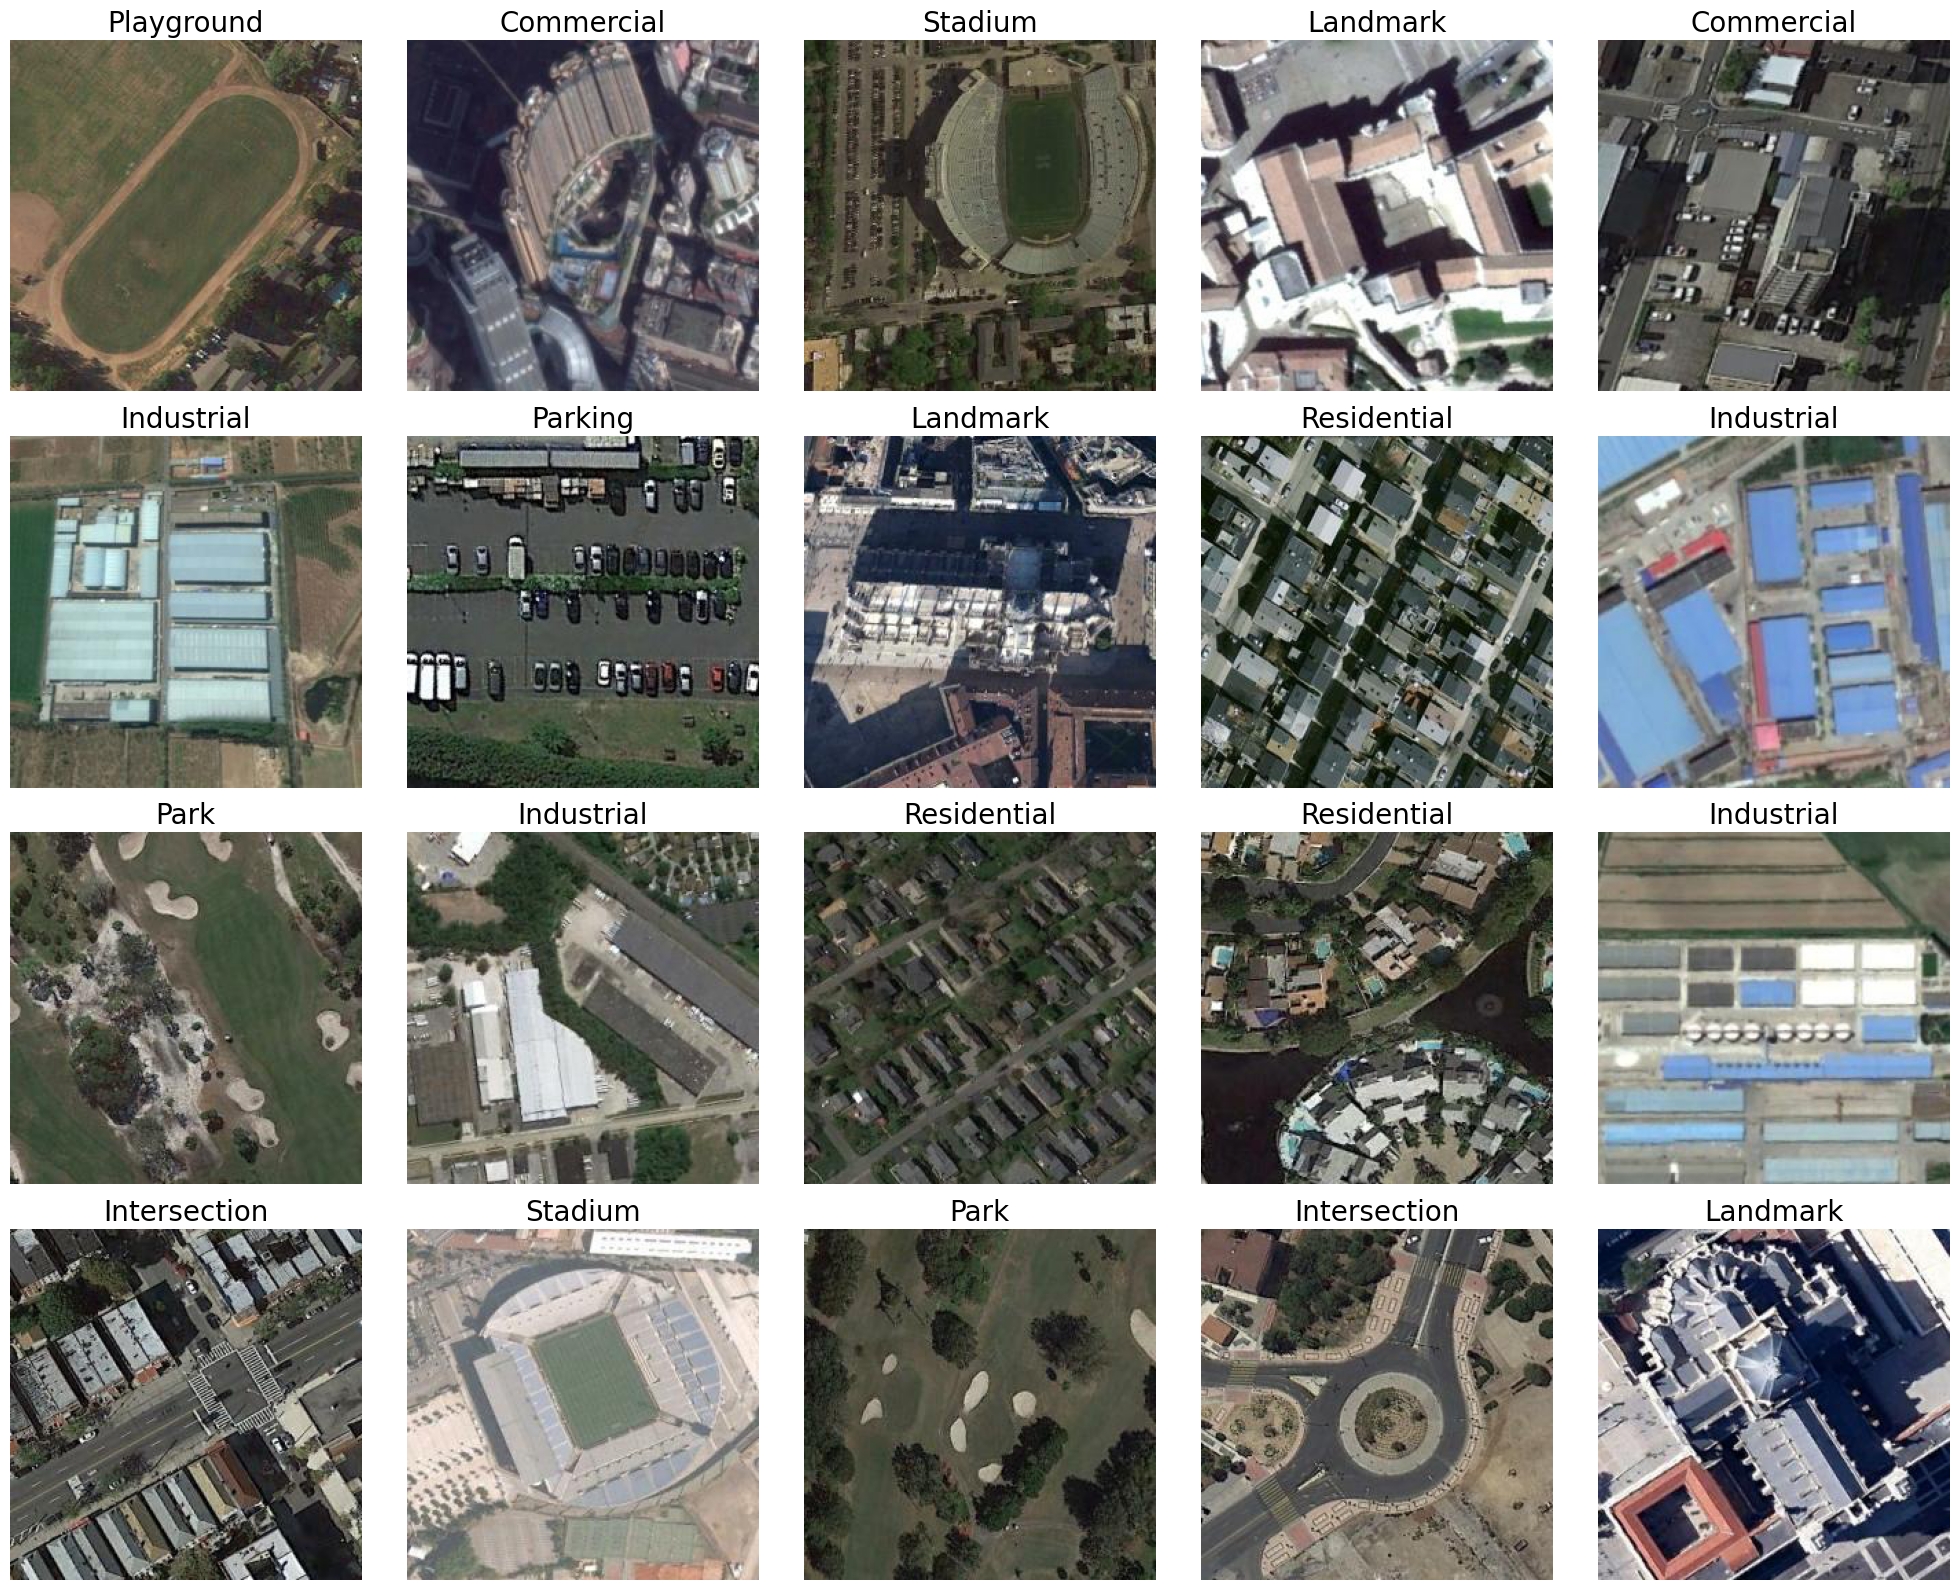

C:\Users\erdal\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,782,666 (33.50 MB)

 Trainable params: 8,782,666 (33.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step - accuracy: 0.1388 - loss: 2.2824 - val_accuracy: 0.3862 - val_loss: 1.7479
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.4005 - loss: 1.6429 - val_accuracy: 0.5094 - val_loss: 1.4515
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.5051 - loss: 1.3759 - val_accuracy: 0.4975 - val_loss: 1.3690
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.5910 - loss: 1.1836 - val_accuracy: 0.5938 - val_loss: 1.1727
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.6383 - loss: 1.0574 - val_accuracy: 0.6712 - val_loss: 0.9740
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.6914 - loss: 0.9030 - val_accuracy: 0.6769 - val_loss: 0.9223
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.7202 - loss: 0.8286 - val_accuracy: 0.6687 - val_loss: 0.9374
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.7442 - loss: 0

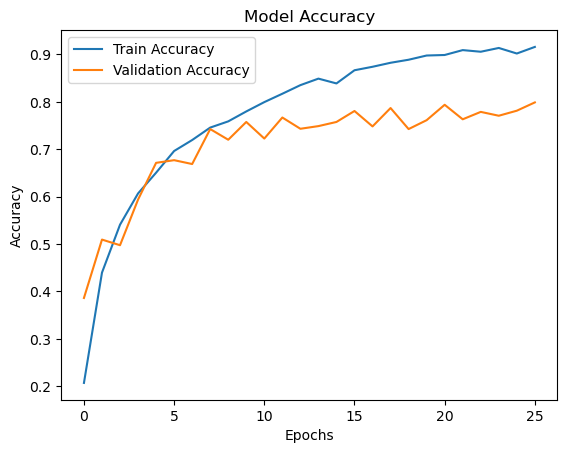

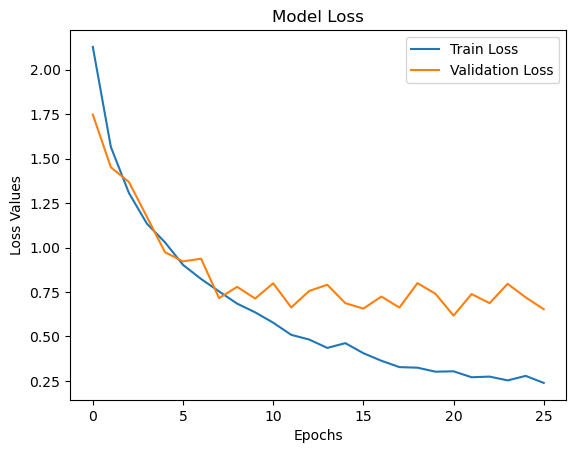

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


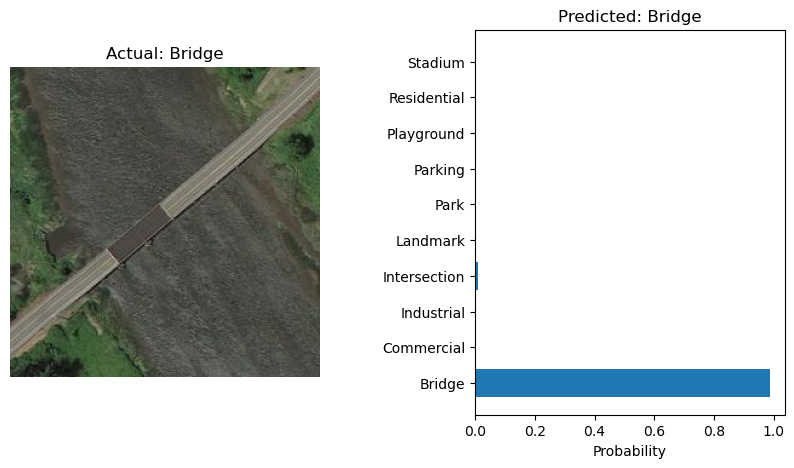

Randomly selected image from class 'Bridge': 333.jpg
Predicted class: 0
Class probabilities: [[9.8789561e-01 1.6212545e-04 5.9197325e-04 9.2314854e-03 4.9718563e-04
  2.5123748e-04 8.5957063e-04 2.8893963e-04 2.5708123e-05 1.9612482e-04]]
Best Validation Metrics:
VAL_ACCURACY: 0.7987


In [14]:
if __name__ == "__main__":
    main()